<a href="https://colab.research.google.com/github/pragmatizt/DS-Unit-2-Applied-Modeling/blob/master/IRA_E_DS7_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install eli5==0.10.1
    !pip install pandas-profiling==2.3.0
    !pip install pdpbox==0.2.0
    !pip install plotly==4.1.1
    !pip install shap==0.30.0

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 112kB 2.9MB/s 
     |████████████████████████████████| 133kB 2.9MB/s 
     |████████████████████████████████| 614kB 40.6MB/s 
     |████████████████████████████████| 225kB 49.4MB/s 
     |████████████████████████████████| 768kB 42.5MB/s 
     |████████████████████████████████| 51kB 20.3MB/s 
     |████████████████████████████████| 194kB 38.3MB/s 
     |████████████████████████████████| 737kB 35.2MB/s 
     |████████████████████████████████| 51kB 19.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=97bc7c3f01937894a454be5492f41dab29faa405afe513e7e85ac746fd419d3d
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=5d9e3c74940c26b1c7ff4abb904c3606806100c4bd78f97109a619ead7cfa5d1
  Stored i

#### Run this cell to load the data:

In [0]:
import pandas as pd
import numpy as np

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

# Part 0: EDA

## **Rounds tracker (revisions after going through all three parts)**
*Current notebook is in Round 10.*
*9/20/2019, 1:48 PM EST*
- Round 1: Dropped violations and License #
- Round 2: Dropped inspection type (this lowered accuracy & ROC score)
- Round 3: Dropped City (this is a Chicago dataset); Null values
- ... (not a fan of doing ffill on na, but if it lets me plot...)
- Round 4: I'm curious what the score will be if I keep all columns.  
- Round 5: dropped State.
- Round 6: make feature: create year, month, day columns; drop "inspection date"; CREATED pdp_interact plot for year and month features.
- Round 7: Location is a duplicate of Longitude, Latitude, and Zip Code.  Dropping it.
- Round 8: Reintroduction of 'Violations' feature to try to increase ROC AUC score. 
- Round 9: Dropping 'DBA Name' and 'AKA Name'.
- **Round 10: Dropping address. (Long, Lat, and Zip covers that data). Added plotly maps.**
- Round 11: Just for kicks.  Should we drop Zip?  Long and Lat cover coords anyway.

In [0]:
print(train.shape)
train.head()

(51916, 17)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [0]:
print(test.shape)
test.head()

(17306, 17)


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,114835,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'...",0
1,1575555,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'...",0
2,671061,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'...",0
3,1965844,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'...",1
4,1751669,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'...",1


In [0]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
test.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,5.191600e+04,5.191100e+04,51890.000000,51718.000000,51718.000000,51916.000000
mean,1.330265e+06,1.549491e+06,60628.834669,41.879568,-87.676663,0.258610
std,6.202664e+05,9.018283e+05,22.736963,0.081126,0.059509,0.437875
min,4.425000e+04,0.000000e+00,60007.000000,41.644670,-87.914428,0.000000
25%,6.796205e+05,1.140745e+06,60614.000000,41.830296,-87.707857,0.000000
50%,1.424226e+06,1.958619e+06,60625.000000,41.890166,-87.666524,0.000000
75%,1.946952e+06,2.215507e+06,60643.000000,41.939167,-87.634461,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [0]:
train.describe(exclude='number')

,DBA Name,AKA Name,Facility Type,Risk,Address,City,State,Inspection Date,Inspection Type,Violations,Location
count,51916,51293,51692,51904,51916,51863,51906,51916,51915,42261,51718
unique,17049,16350,329,3,13954,39,1,2257,51,42164,13410
top,SUBWAY,SUBWAY,Restaurant,Risk 1 (High),11601 W TOUHY AVE,CHICAGO,IL,2017-03-23T00:00:00,Canvass,45. FOOD HANDLER REQUIREMENTS MET - Comments: ...,"{'longitude': '-87.91442843927047', 'latitude'..."
freq,654,802,34264,37731,741,51659,51906,50,24170,3,741


In [0]:
# Looking for the leakage.
# Inspection Type: has observations that are "reinspections";
# Could that be a leakage -- since obviously they would have failed
# previously.

# about 12,000 observations have "re-inspection" in them.  
# dropping this the second time around then.  

train['Inspection Type'].value_counts()

In [0]:
train['Violations'].value_counts()

In [0]:
train['Risk'].value_counts()

Risk 1 (High)      37731
Risk 2 (Medium)    10136
Risk 3 (Low)        4037
Name: Risk, dtype: int64

In [0]:
train['License #'].value_counts()

# Originally thought to check this if there's leakages (i.e. - 
# if they don't have a license; then they would have failed(?) inspection)

# But will drop anyway since it is just a unique identifier, and 
# we have inspection ID as a column.

In [0]:
train['Inspection ID'].value_counts()
# Keeping this in case I can use it for Shapley visualizations later. 

In [0]:
# Looking for null values

train.isnull().sum()

# (ROUND 1) Dropping: Violations (42K unique cat observations)
# (ROUND 2) Forward fill on nan values.  (pdp_isolate won't work on null vals)

In [0]:
train['Location'].value_counts()

In [0]:
# Round 2 (my second time around after doing MVP) 
# cleaning of null values

In [0]:
train['City'].value_counts()

In [0]:
train['Inspection Date'].value_counts()

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
# Round 3 - forward filling NaN values.  
# ... my pdp_isolate plot wouldn't work with nulls.

train = train.fillna(method='ffill')


In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                             stratify=train['Fail'], random_state=42)

In [0]:
train.shape, val.shape, test.shape

((41532, 17), (10384, 17), (17306, 17))

In [0]:
# Start with these wrangles for now, and build upon it later.

def wrangle(X):
  
  X = X.copy()
  
  # Dropping suspected "LEAKAGE"
  X = X.drop(columns=['Inspection Type'])
  
  # Drop columns with high cardinality
  X = X.drop(columns=['License #', 'DBA Name', 'AKA Name'])
  
  # Drop duplicates.  Longitude, Latitude, and Zip has all info we need.
  X = X.drop(columns=['City', 'State', 'Location', 'Address'])
 
  # Long and Lat have zeros in them; they shouldn't.  Let's replace zeros
  # nulls and impute missing values later
  cols_with_zeros = ['Longitude', 'Latitude']
  for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)
  
  # Create a "Year" column
  X['Inspection Date'] = pd.to_datetime(X['Inspection Date'], infer_datetime_format=True)
  
  # Extract components from date_recorded, then drop the original column
  X['Year_Inspected'] = X['Inspection Date'].dt.year
  X['Month_Inspected'] = X['Inspection Date'].dt.month
  X['Day_Inspected'] = X['Inspection Date'].dt.day
  X = X.drop(columns='Inspection Date')
  
  return X

In [0]:
# Pass the wrangle function on train, val, and test.

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Checking columns
train.columns

Index(['Inspection ID', 'Facility Type', 'Risk', 'Zip', 'Violations',
       'Latitude', 'Longitude', 'Fail', 'Year_Inspected', 'Month_Inspected',
       'Day_Inspected'],
      dtype='object')

In [0]:
val.columns

Index(['Inspection ID', 'Facility Type', 'Risk', 'Zip', 'Violations',
       'Latitude', 'Longitude', 'Fail', 'Year_Inspected', 'Month_Inspected',
       'Day_Inspected'],
      dtype='object')

In [0]:
# Interesting breakdown of years.
train['Year_Inspected'].value_counts(normalize=True, ascending=True)

2019    0.009968
2018    0.067466
2012    0.106857
2013    0.108230
2015    0.112877
2010    0.114731
2017    0.115887
2011    0.117139
2014    0.118848
2016    0.127998
Name: Year_Inspected, dtype: float64

In [0]:
train['Month_Inspected'].value_counts(normalize=True, ascending=True)

12    0.067418
7     0.070042
11    0.075364
2     0.077145
8     0.082611
1     0.084128
4     0.086078
10    0.087619
9     0.088895
6     0.092772
3     0.093109
5     0.094818
Name: Month_Inspected, dtype: float64

In [0]:
target = 'Fail'

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test.drop(columns=target)
y_test = test[target]

In [0]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

# Part 1 is fulfilled.

((41532, 10), (41532,), (10384, 10), (10384,), (17306, 10), (17306,))

# Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
y_train.head()

13409    0
42587    1
228      0
40468    0
37472    0
Name: Fail, dtype: int64

In [0]:
# Imports here:

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Encoding
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# ROC AUC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [0]:
y_train.value_counts(normalize=True)

# Our majority class are establishments that passed inspection.
# 74% passed, 25.8% failed inspections.

0    0.74138
1    0.25862
Name: Fail, dtype: float64

In [0]:
# Fit on train

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Facility Type', 'Risk', 'Violations'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Facility Type',
                                          'data_type': dtype('O'),
                                          'mapping': Restaurant                                     1
Grocery Store                                  2
School                                         3
Daycare Above and Under 2 Years                4
Bakery                                         5
PALETERIA                                      6
Mobile Food Preparer                           7
COFFEE VENDING MACHINE                         8
S...
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                              

In [0]:
y_pred = pipeline.predict(X_val)
accuracy_score(y_val, y_pred)

print('Accuracy Score:', accuracy_score(y_val, y_pred))

# our accuracy score beats the baseline.

Accuracy Score: 0.7335323574730355


In [0]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

print('ROC AUC Score:', roc_auc_score(y_val, y_pred_proba))

# First time around of testing this - I got 68%.  

ROC AUC Score: 0.6010181495916058


In [0]:
print('Accuracy Score, Round 1: 0.7478813559322034') # dropped violations, license #
print('Accuracy Score, Round 2: 0.713020030816641') # dropped inspection type
print('Accuracy Score, Round 3: 0.710997688751926') # Dropped city
print('Accuracy Score, Round 4: 0.7400808936825886') # no dropped columns
print('Accuracy Score, Round 5: 0.7079160246533128') # dropped State (re-dropped prev cols)
print('Accuracy Score, Round 6: 0.712442218798151') # Created yr, months, day cols
print('Accuracy Score, Round 7: 0.7128274268104776') # dropped location
print('Accuracy Score, Round 8: Oops, forgot to record data')
print('Accuracy Score, Round 9: 0.7381548536209553') # dropped names, so close.
print('Accuracy Score, Round 10: 0.7335323574730355') # <-- this is our winner.
print('Accuracy Score, Round 11: 0.7327619414483821') # Drop zip; lowered score

print('\nROC AUC Score, Round 1: 0.6831758362775596')
print('ROC AUC Score, Round 2: 0.5488300857955627') # dropped inspection type 
print('ROC AUC Score, Round 3: 0.5480896089675725') # dropped city, ffill NaNs
print('ROC AUC Score, Round 4: 0.6171467527161983') # no dropped columns
print('ROC AUC Score, Round 5: 0.5474446970428093') # dropped State.
print('ROC AUC Score, Round 6: 0.538358726604316') # Created yr, months, day cols
print('ROC AUC Score, Round 7: 0.5458590355999219') # dropped location
print('ROC AUC Score, Round 8: Oops, forgot to record data')
print('ROC AUC Score, Round 9: 0.5907823526864961') # dropped named.  So close.
print('ROC AUC Score, Round 10: 0.6010181495916058') # dropped address. <-- winner.
print('ROC AUC Score, Round 11: 0.5940317770839184') # dropped zip; lowered.

Accuracy Score, Round 1: 0.7478813559322034
Accuracy Score, Round 2: 0.713020030816641
Accuracy Score, Round 3: 0.710997688751926
Accuracy Score, Round 4: 0.7400808936825886
Accuracy Score, Round 5: 0.7079160246533128
Accuracy Score, Round 6: 0.712442218798151
Accuracy Score, Round 7: 0.7128274268104776
Accuracy Score, Round 8: Oops, forgot to record data
Accuracy Score, Round 9: 0.7381548536209553
Accuracy Score, Round 10: 0.7335323574730355
Accuracy Score, Round 11: 0.7327619414483821

ROC AUC Score, Round 1: 0.6831758362775596
ROC AUC Score, Round 2: 0.5488300857955627
ROC AUC Score, Round 3: 0.5480896089675725
ROC AUC Score, Round 4: 0.6171467527161983
ROC AUC Score, Round 5: 0.5474446970428093
ROC AUC Score, Round 6: 0.538358726604316
ROC AUC Score, Round 7: 0.5458590355999219
ROC AUC Score, Round 8: Oops, forgot to record data
ROC AUC Score, Round 9: 0.5907823526864961
ROC AUC Score, Round 10: 0.6010181495916058
ROC AUC Score, Round 11: 0.5940317770839184


## Leakage.
I am almost certain at this point that the leakage is the 'Inspection Type'.  My hunch in the beginning was that "re-inspections" in observations would naturally give "future information" (because it implies the facility already failing once);

And when I saw that my Accuracy and ROC AUC scores plummeted (3 and 12 points, respectively) after dropping Inspection Type, I am fairly certain it is.

# Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

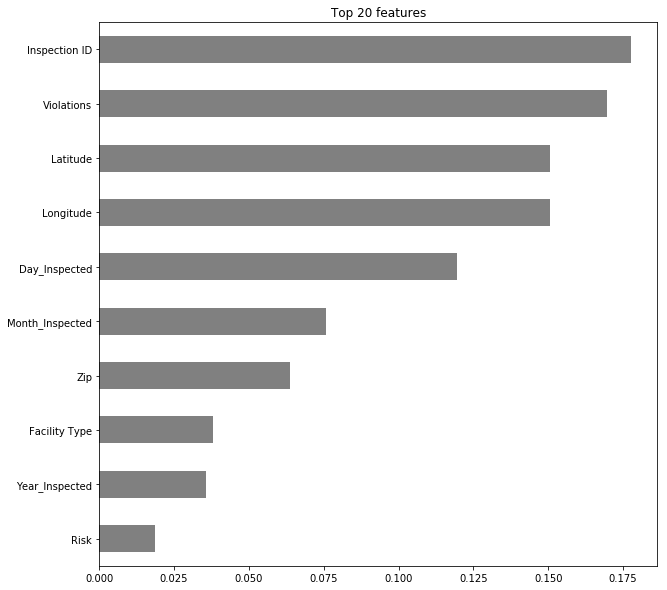

In [0]:
# Permutation Importances

rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10, n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

# interesting - our top features are Inspection ID, and Inspection date, 
# and then coordinates.  

In [0]:
# Let's encode it.

transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
# Bring in the PermutationImportance library
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

Using TensorFlow backend.


In [0]:
permuter = PermutationImportance(
    model,
    scoring='accuracy',
    n_iter=2,
    random_state=42,
)

permuter.fit(X_val_transformed, y_val)  
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0021 ± 0.0015,Inspection ID
0.0021 ± 0.0005,Violations
0.0014 ± 0.0051,Day_Inspected
-0.0004 ± 0.0003,Risk
-0.0006 ± 0.0012,Facility Type
-0.0021 ± 0.0020,Month_Inspected
-0.0023 ± 0.0023,Latitude
-0.0032 ± 0.0014,Year_Inspected
-0.0044 ± 0.0006,Longitude
-0.0048 ± 0.0007,Zip


In [0]:
'''
Longitude really sticks out here.  I wonder, if location also has a 
higher proportion for establishments that fail. 
Low income, high turnover, etc.')
'''

"\nLongitude really sticks out here.  I wonder, if location also has a \nhigher proportion for establishments that fail. \nLow income, high turnover, etc.')\n"

In [0]:
# Partial Dependence Plot

In [0]:
train.columns

Index(['Inspection ID', 'Facility Type', 'Risk', 'Zip', 'Violations',
       'Latitude', 'Longitude', 'Fail', 'Year_Inspected', 'Month_Inspected',
       'Day_Inspected'],
      dtype='object')

In [0]:
feature0 = 'Zip'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature0
)

# Kept getting a "no objects to concatenate" error on this.
# After googling, due to Null values.
# Going back to pre-processing and cleaning some columns.

In [0]:
feature1 = 'Latitude'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature1
)

In [0]:
feature2 = 'Longitude'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature2
)

In [0]:
feature3 = 'Year_Inspected'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature3
)

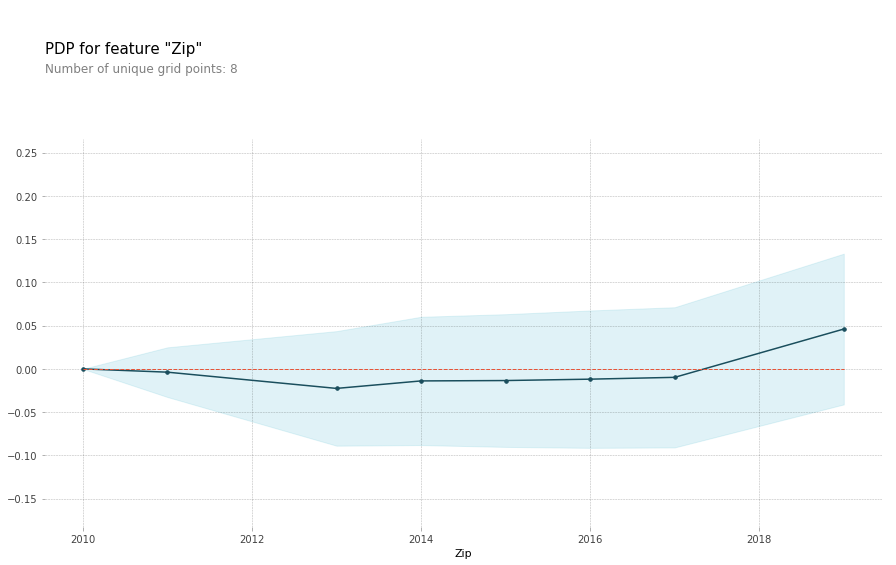

In [0]:
# PDP plot for 'Zip'
pdp_plot(isolated, feature_name=feature0);


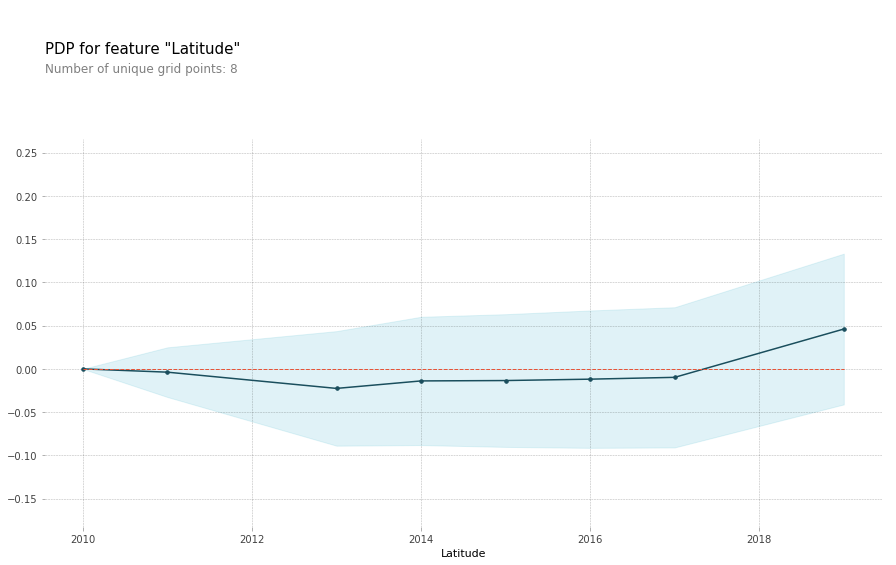

In [0]:
# PDP plot for 'Latitude'
pdp_plot(isolated, feature_name=feature1);

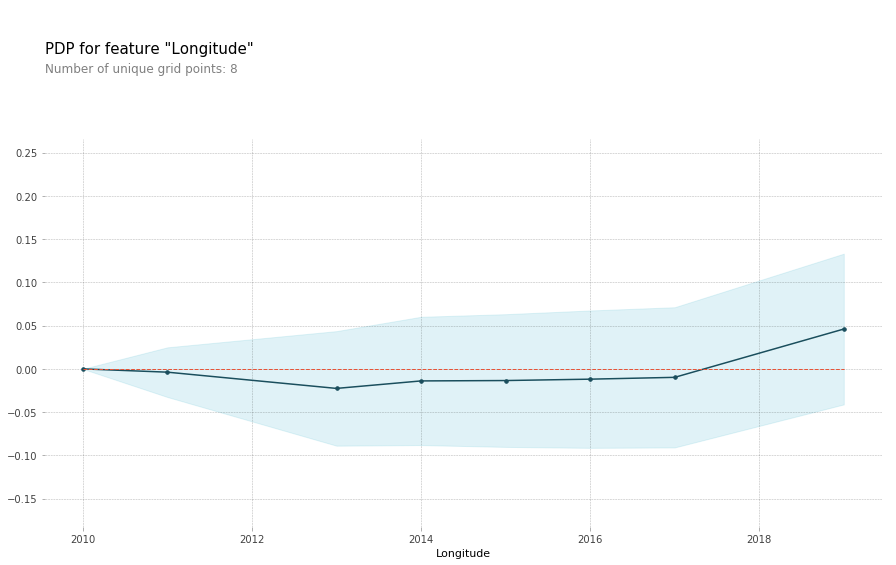

In [0]:
# PDP plot for 'Latitude'
pdp_plot(isolated, feature_name=feature2);

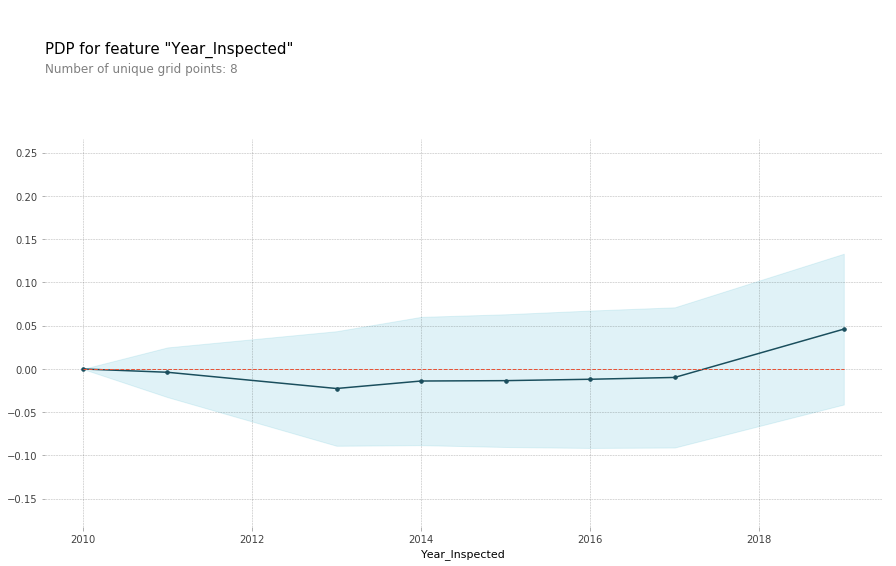

In [0]:
# PDP plot for 'Year_Inspected'
# Interesting - The line (and confidence interval(?) seems to be...
# trending upwards after 2017.)
pdp_plot(isolated, feature_name=feature3);

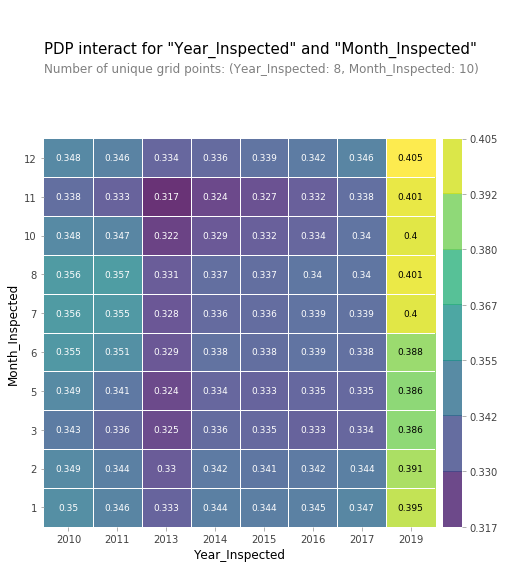

In [0]:
grid = isolated.feature_grids
pdp = isolated.pdp

grid = isolated.feature_grids

features = ['Year_Inspected', 'Month_Inspected']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);


**That's interesting.**  Take note of all of 2019.  Very high numbers, across all months in comparison to 2017.

What is that?  An error in our model?  An incumbent administration that is more stringent on inspection protocols resulting in higher failures?

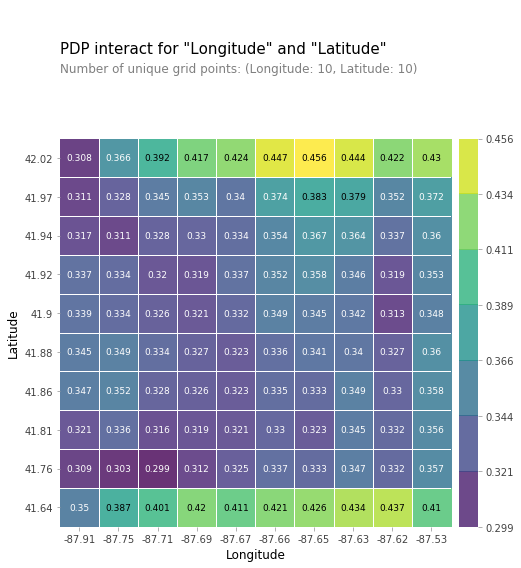

In [0]:
# pdp_interact plot.  Longitude and Lat  

grid = isolated.feature_grids
pdp = isolated.pdp

grid = isolated.feature_grids

features = ['Longitude', 'Latitude']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

**Would love to investigate this further; but look at yellows on PDP interact map above:**
- Coordinates (42.02, -87.65) is sky high (0.456). 
- Other high coordinates: (42.02, -87.66)

## Just for fun, create a plotly map

In [0]:
# Let's see if we can visualize this on a map. 

import plotly.express as px
px.scatter(train, x='Longitude', y='Latitude', color='Fail', opacity=0.1)

In [0]:
fig = px.scatter_mapbox(train, lat='Latitude', lon='Longitude', color='Fail', opacity=0.1)
fig.update_layout(mapbox_style='stamen-terrain')
fig.show()

From a (prone to error) "eye test", looks like places further from the shore.

But that's a very different result that I got from the PDP plot -- the boxes in yellow (higher; closer to 1) were on the northeast corner of Chicago.